In [1]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest


In [2]:
all_state_weekly_data = pd.read_csv("all_state_weekly_data_cases_deaths_admissions_hospital.csv")
all_state_weekly_data = all_state_weekly_data.loc[:, all_state_weekly_data.columns != 'Unnamed: 0']
all_state_weekly_data = all_state_weekly_data.fillna(0)

In [4]:
column_names = ['state']
categories_for_subsetting = ['deaths', 'cases', 'hospitalizations', 'hospitalizations_delta_100k', 'admissions','admissions_delta_100k', 'over_15_100k']

for week in range(1, len(all_state_weekly_data) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)


state_abb = []
for column in all_state_weekly_data.columns:
    state_abb.append(column[:2])
state_abb = set(state_abb[1:])


In [5]:
all_state_weekly_data_by_state = pd.DataFrame(index=range(51), columns=column_names)

x = 0

categories_for_subsetting = ['deaths', 'cases', 'hospitalizations', 'hospitalizations_delta_100k', 'admissions','admissions_delta_100k', 'over_15_100k']
for abb in state_abb:
    matching_indices = [i for i, state in enumerate(all_state_weekly_data) if state == abb]
    all_state_weekly_data_by_state.loc[x, 'state'] = abb
    columns_to_subset =  [f'{abb}_{category}' for category in categories_for_subsetting]
    j = 1
    for row in range(len(all_state_weekly_data.loc[:, columns_to_subset])):
        all_state_weekly_data_by_state.iloc[x, j:j + len(categories_for_subsetting)] = all_state_weekly_data.loc[row,columns_to_subset]
        j += 7
    x += 1

#all_state_weekly_data_by_state.set_index('state', inplace = True)

In [6]:
target_months= [col for col in all_state_weekly_data_by_state.columns if 'week_four_' in col]
X_train = all_state_weekly_data_by_state[target_months[0:len(target_months)-1]]
X_train.columns = range(1, len(X_train.columns) + 1)

y_train = all_state_weekly_data_by_state[target_months[-1]].astype(int)
X_train, y_train = oversample.fit_resample(X_train, y_train)


test_months= [col for col in all_state_weekly_data_by_state.columns if 'week_twenty_' in col]

X_test = all_state_weekly_data_by_state[test_months[0:len(test_months)-1]]
X_test.columns = range(1, len(X_test.columns) + 1)

y_test = all_state_weekly_data_by_state[test_months[-1]].astype(int)

In [7]:

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the decision tree classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9607843137254902
[[11  0]
 [ 2 38]]


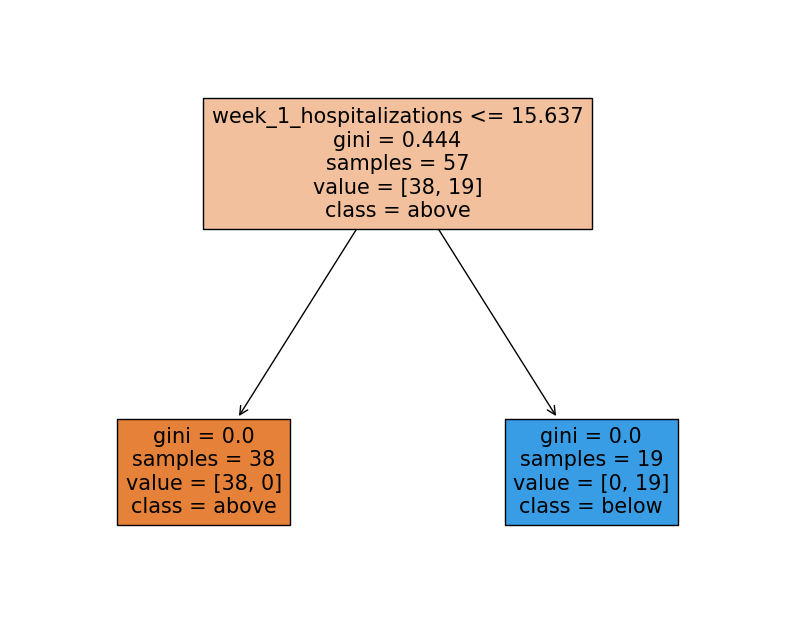

In [8]:
plt.figure(figsize=(10, 8))
plot_tree(clf, feature_names=['week_1_deaths',	'week_1_cases',	'week_1_hospitalizations',	'week_1_hospitalizations_delta_100k	week_1_admissions',	'week_1_admissions_delta_100k'], class_names=['above', 'below'], filled=True)
plt.show()

# Try counties 

In [84]:
data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/County_level_hospitalizations_death.csv')
data_by_county.columns
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])


Some counties have the same name as others - need to make them unique 

In [96]:
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
len(data_by_county['CTYNAME'].unique())


3209

In [30]:
data_by_county.columns

Index(['Unnamed: 0', 'fips', 'date', 'state', 'cases_avg', 'deaths_avg',
       'chk1', 'chk2', 'STNAME', 'POPESTIMATE2019', 'CTYNAME', 'ABBR', 'ymd',
       'year', 'week', 'year_wk', 'cases_avg_per_100k', 'deaths_avg_per_100k',
       'health_service_area_population.x', 'admits_confirmed_avg',
       'perc_covid', 'admits_confirmed_100K', 'icu_100K', 'beds_100k',
       'cdc_flag_1', 'cdc_flag_2', 'cdc_flag', 'deaths_21_lag_100k',
       'icu_21_lag_100K', 'cases_lag_21_100K', 'admits_7_lag', 'admits_7d_ago',
       'admits_21d_ago', 'admits_28d_ago', 'dotw', 'chk', 'county_rank',
       'deaths_21_lag_100k_14d', 'deaths_weekly', 'admits_weekly',
       'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid_100', 'cfr',
       'half_zeke_time_3', 'zeke_time_3', 'two_zeke_time_3', 'icu_2_time_3',
       'zeke_time_3_14d', 'two_zeke_time_3_14d', 'weight', 'weight_alt'],
      dtype='object')

Create target data 
For the moment, do > 15 admits per 100k

In [31]:
#data_by_county.fillna(0)
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15)*1


In [32]:

data_by_county_cases = data_by_county[['CTYNAME', 'week', 'cases_weekly']]
data_by_county_cases = data_by_county_cases.pivot_table(index= 'week', columns='CTYNAME', values='cases_weekly')
data_by_county_deaths = data_by_county[['CTYNAME', 'week', 'deaths_weekly']]
data_by_county_deaths = data_by_county_deaths.pivot_table(index= 'week', columns='CTYNAME', values='deaths_weekly')
data_by_county_admissions = data_by_county[['CTYNAME', 'week', 'admits_weekly']]
data_by_county_admissions = data_by_county_admissions.pivot_table(index= 'week', columns='CTYNAME', values='admits_weekly')
data_by_county_icu = data_by_county[['CTYNAME', 'week', 'icu_weekly']]
data_by_county_icu = data_by_county_icu.pivot_table(index= 'week', columns='CTYNAME', values='icu_weekly')
data_by_county_beds = data_by_county[['CTYNAME', 'week', 'beds_weekly']]
data_by_county_beds = data_by_county_beds.pivot_table(index= 'week', columns='CTYNAME', values='beds_weekly')
data_by_county_over_15_100k = data_by_county[['CTYNAME', 'week', 'beds_over_15_100k']]
data_by_county_over_15_100k = data_by_county_over_15_100k.pivot_table(index= 'week', columns='CTYNAME', values='beds_over_15_100k')
#data_by_county_over_15_100k = data_by_county_over_15_100k.add_suffix('_beds_over_15_100k')



data_data_cases_death_weekly = pd.merge(data_by_county_cases, data_by_county_deaths, on='week')
new_column_names = [col.replace('_x', '_cases') for col in data_data_cases_death_weekly.columns]
data_data_cases_death_weekly.rename(columns=dict(zip(data_data_cases_death_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_deaths') for col in data_data_cases_death_weekly.columns]
data_data_cases_death_weekly.rename(columns=dict(zip(data_data_cases_death_weekly.columns, new_column_names)), inplace=True)

data_data_admits_icu_weekly = pd.merge(data_by_county_admissions, data_by_county_icu, on='week')
new_column_names = [col.replace('_x', '_admit') for col in data_data_admits_icu_weekly.columns]
data_data_admits_icu_weekly.rename(columns=dict(zip(data_data_admits_icu_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_icu') for col in data_data_admits_icu_weekly.columns]
data_data_admits_icu_weekly.rename(columns=dict(zip(data_data_admits_icu_weekly.columns, new_column_names)), inplace=True)

data_data_beds_over_weekly = pd.merge(data_by_county_beds, data_by_county_over_15_100k, on='week')
new_column_names = [col.replace('_x', '_beds') for col in data_data_beds_over_weekly.columns]
data_data_beds_over_weekly.rename(columns=dict(zip(data_data_beds_over_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_beds_over_15_100k') for col in data_data_beds_over_weekly.columns]
data_data_beds_over_weekly.rename(columns=dict(zip(data_data_beds_over_weekly.columns, new_column_names)), inplace=True)



data_by_county_cases_deaths_admits_icu = pd.merge(data_data_cases_death_weekly, data_data_admits_icu_weekly, on='week')
data_by_county_cases_deaths_admits_icu_beds = pd.merge(data_by_county_cases_deaths_admits_icu, data_data_beds_over_weekly, on='week')
data_by_county_cases_deaths_admits_icu_beds = data_by_county_cases_deaths_admits_icu_beds.reset_index()



In [33]:
data_by_county_cases_deaths_admits_icu_beds.columns = [col.split()[0] for col in data_by_county_cases_deaths_admits_icu_beds.columns]


In [9]:
data_by_county_cases_deaths_admits_icu_beds.to_csv("County_level_hospitalizations_death_by_county.csv")

In [25]:
data_data_cases_death_weekly.plot()

<Axes: xlabel='week'>

ValueError: Image size of 569x135384 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

<Axes: >

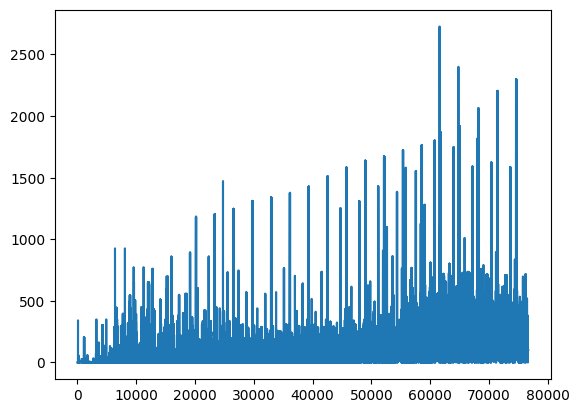

In [23]:
data_by_county['beds_weekly'].plot()

In [34]:
column_names = ['county']
categories_for_subsetting = ['cases', 'deaths', 'admit', 'icu', 'beds', 'beds_over_15_100k']

for week in range(1, len(data_by_county_cases_deaths_admits_icu_beds) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)



In [348]:
all_county_weekly_data = pd.DataFrame(index=range(51), columns=column_names)

x = 0

categories_for_subsetting = ['cases', 'deaths', 'admit', 'icu', 'beds', 'beds_over_15_100k']
for county in data_by_county['CTYNAME'].unique():
    matching_indices = [i for i, county_col in enumerate(data_by_county_cases_deaths_admits_icu_beds) if county_col == county]
    all_county_weekly_data.loc[x, 'county'] = county
    columns_to_subset =  tuple([f'{county}_{category}' for category in categories_for_subsetting]) 
    columns_to_subset =  [f'{county}_{category}' for category in categories_for_subsetting]

    j = 1
    try:
        for row in range(len(data_by_county_cases_deaths_admits_icu_beds.loc[:, columns_to_subset])):
            all_county_weekly_data.iloc[x, j:j + len(categories_for_subsetting)] = data_by_county_cases_deaths_admits_icu_beds.loc[row,columns_to_subset]
            j += 6
    except:
        pass
    x += 1


In [ ]:
### What i could do is, for each week, take something four weeks in advance and just create a larger dataset

In [410]:
def prep_training_test_data(data, proportion, no_weeks, weeks_in_futre, if_train, geography, weight_col):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    for x_week in x_weeks:
            y_week = y_weeks[0]
            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and the "target" for that week

            #rename columns for concatenation 
            X_week.columns = range(1, len(data_x.columns) -2)
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)




Calculate trends across weeks

In [41]:
for column in all_county_weekly_data.columns[1:]:
    # Calculate the difference between each row and the previous row
    if "over" not in column.lower():
        diff = all_county_weekly_data[column].diff()
        
        # Create a new column with the original column name and "delta"
        new_column_name = column + "_delta"
        
        column_index = all_county_weekly_data.columns.get_loc(column)
        
        # Insert the new column just after the original column
        all_county_weekly_data.insert(column_index + 1, new_column_name, diff)
        all_county_weekly_data[new_column_name] = diff

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3448/3363159048.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_county_weekly_data.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3448/3363159048.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_county_weekly_data.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3448/3363159048.py:12: PerformanceWarning: DataFrame is highly fragmented.  T

In [401]:
weights_df = data_by_county[data_by_county['CTYNAME'].isin(all_county_weekly_data['county'])][['CTYNAME','weight_alt']]
weights_df = weights_df.rename(columns = {'CTYNAME': 'county', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_county_weekly_data = all_county_weekly_data.join(weights_df['weight'])


In [428]:
#X_train, y_train = prep_training_test_data(all_county_weekly_data, [3,2], no_weeks = range(1, int(24*2/3) + 1), weeks_in_futre = 4, if_train = True)
X_train, y_train, weights, missing_data_train = prep_training_test_data(all_county_weekly_data, [3,2], no_weeks = range(1, int(24*2/3) + 1), weeks_in_futre = 4, if_train = True, geography = 'county', weight_col = 'weight')

X_test, y_test, weights_test,missing_data_test = prep_training_test_data(all_county_weekly_data, [3,2], no_weeks = range(int(24*2/3) + 1, 25), weeks_in_futre = 4, if_train = False, geography = 'county',  weight_col = 'weight')

weights = weights[0]

[2.5864755375506387, 1.8074166406980368, 1.5581177937052042, 1.0595200997195389, 0.9971953879713306, 0.9971953879713306, 0.9971953879713306, 1.1530071673418512, 0.9971953879713306, 0.9971953879713306, 1.0595200997195389, 1.0595200997195389, 0.9971953879713306, 0.9971953879713306, 0.9971953879713306, 0.9971953879713306]
19.258335930196324
[0.21813649111872857, 0.21813649111872857, 0.21813649111872857, 0.1558117793705204, 0.1558117793705204, 0.1558117793705204, 0.1558117793705204, 0.1558117793705204]
1.4334683702087878


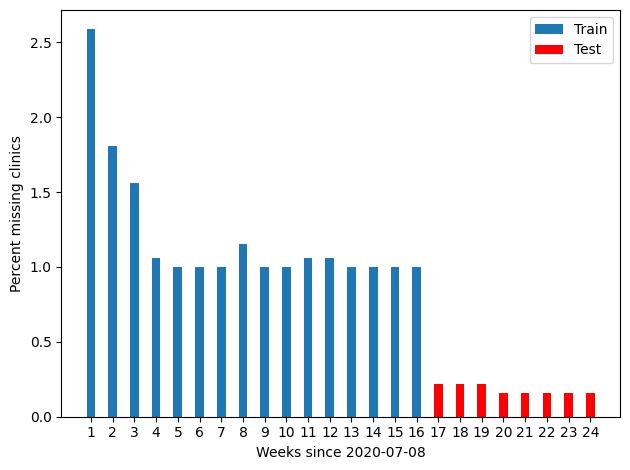

In [426]:
print(missing_data_train)
print(sum(missing_data_train))
print(missing_data_test)
print(sum(missing_data_test))

width = 0.4
x = np.arange(len(missing_data_train) + len(missing_data_test))
fig, ax = plt.subplots()
ax.bar(x[:len(missing_data_train)], missing_data_train, width, label='Train')
ax.bar(x[len(missing_data_train):], missing_data_test, width, label='Test', color='red')

# Labels and title
ax.set_xlabel('Weeks since 2020-07-08')
ax.set_ylabel('Percent missing clinics')
ax.set_xticks(x)
ax.set_xticklabels(labels = x+1, rotation=0, fontsize=10)

ax.legend()

plt.tight_layout()

plt.savefig('Graphs/Percent_missing_counties.png', dpi = 300)

Percentage of missing data

In [115]:

target_week = ['_ten_', '_fourteen_']

target_months1= [col for col in all_county_weekly_data.columns if target_week[0] in col]
target_columns1 = ['county'] + target_months1
train_data1= all_county_weekly_data[target_columns1]
train_data1 = train_data1[train_data1['county'].isin(first_two_thirds)]

train_data1.columns = range(1, len(train_data1.columns) + 1)
target_months2= [col for col in all_county_weekly_data.columns if target_week[1] in col]
target_columns2 = ['county'] + target_months2
train_data2= all_county_weekly_data[target_columns2]
train_data2 = train_data2[train_data2['county'].isin(first_two_thirds)]

train_data2.columns = range(1, len(train_data2.columns) + 1)
# Remove rows in train_data1 with NA in train_data2
train_data1 = train_data1.dropna(subset=range(2, len(train_data1.columns) + 1))
train_data1 = train_data1.dropna()

# Remove rows in train_data2 with NA in train_data1
train_data2 = train_data2.dropna(subset=range(2, len(train_data2.columns) + 1))
train_data2 = train_data2.dropna()

X_train = train_data1.iloc[:, 1:len(target_months1)]
X_train.columns = range(1, len(X_train.columns) + 1)
y_train = train_data2.iloc[:, len(target_months1)]
y_train = y_train.astype(int)

X_train, y_train = oversample.fit_resample(X_train, y_train)

target_months1= [col for col in all_county_weekly_data.columns if target_week[0] in col]
target_columns1 = ['county'] + target_months1
test_data1= all_county_weekly_data[target_columns1]
test_data1 = test_data1[test_data1['county'].isin(last_third)]

target_months2= [col for col in all_county_weekly_data.columns if target_week[1] in col]
target_columns2 = ['county'] + target_months2
test_data2= all_county_weekly_data[target_columns2]
test_data2 = test_data2[test_data2['county'].isin(last_third)]

# Remove rows in test_data1 with NA in test_data2
test_data1 = test_data1.dropna()
test_data1 = test_data1[test_data1['county'].isin(test_data2['county'])]

# Remove rows in test_data2 with NA in test_data1
test_data2 = test_data2.dropna()
test_data2 = test_data2[test_data2['county'].isin(test_data1['county'])]
test_data1 = test_data1[test_data1['county'].isin(test_data2['county'])]

test_data1.columns = range(1, len(test_data1.columns) + 1)
test_data2.columns = range(1, len(test_data2.columns) + 1)

X_test = test_data1.iloc[:, 1:len(target_months1)]
X_test.columns = range(1, len(X_test.columns) + 1)
y_test = test_data2.iloc[:, len(target_months1)]
y_test = y_test.astype(int)

Accuracy: 0.895841475807082
auROC: 0.895841475807082
[[  300   100]
 [ 2565 22621]]


IndexError: list index out of range

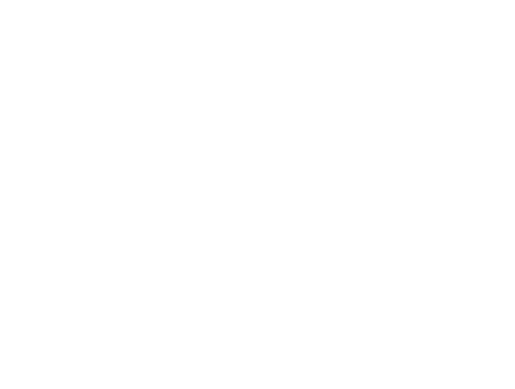

In [43]:
# Create a decision tree classifier
param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(50, 200),
    'min_samples_leaf': np.arange(50, 200)
}

param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 100) #100, 200, 300, 400, 500], #np.arange(500, 200)
}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10)

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10)

# Train the decision tree classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'delta_cases', 'deaths', 'delta_death','admit', 'delta_admits','icu', 'delta_icu','beds', 'delta_beds'	], class_names=['above', 'below'], filled=True)


Number of nodes in the last tree is: 1 with ccp_alpha: 0.10679727190425392


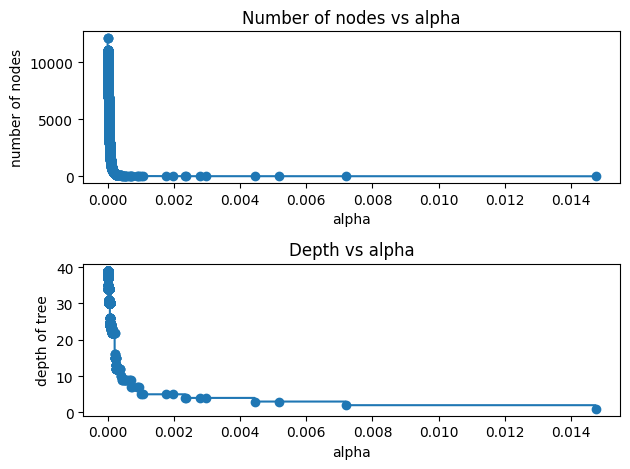

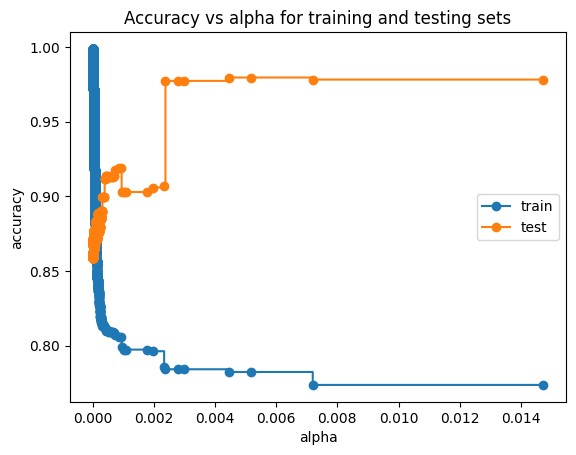

Best Hyperparameters:  {'min_samples_split': 40, 'min_samples_leaf': 68, 'max_depth': 7, 'criterion': 'gini', 'ccp_alpha': 0.0006000000000000001}
Best Score:  0.8072633254321835
Accuracy: 0.9131165481122488
[[  310    90]
 [ 2133 23053]]


[Text(0.4296875, 0.9375, 'beds <= 15.88\ngini = 0.444\nsamples = 57412\nvalue = [19136, 38276]\nclass = below'),
 Text(0.171875, 0.8125, 'delta_beds <= -0.697\ngini = 0.448\nsamples = 19073\nvalue = [12606, 6467]\nclass = above'),
 Text(0.09375, 0.6875, 'beds <= 10.02\ngini = 0.366\nsamples = 10089\nvalue = [7659, 2430]\nclass = above'),
 Text(0.0625, 0.5625, 'admit <= 0.046\ngini = 0.316\nsamples = 8104\nvalue = [6509, 1595]\nclass = above'),
 Text(0.03125, 0.4375, 'gini = 0.252\nsamples = 4227\nvalue = [3601, 626]\nclass = above'),
 Text(0.09375, 0.4375, 'gini = 0.375\nsamples = 3877\nvalue = [2908, 969]\nclass = above'),
 Text(0.125, 0.5625, 'gini = 0.487\nsamples = 1985\nvalue = [1150, 835]\nclass = above'),
 Text(0.25, 0.6875, 'cases <= 21.5\ngini = 0.495\nsamples = 8984\nvalue = [4947, 4037]\nclass = above'),
 Text(0.1875, 0.5625, 'cases <= 9.5\ngini = 0.395\nsamples = 3078\nvalue = [2243, 835]\nclass = above'),
 Text(0.15625, 0.4375, 'gini = 0.308\nsamples = 1481\nvalue = [1199,

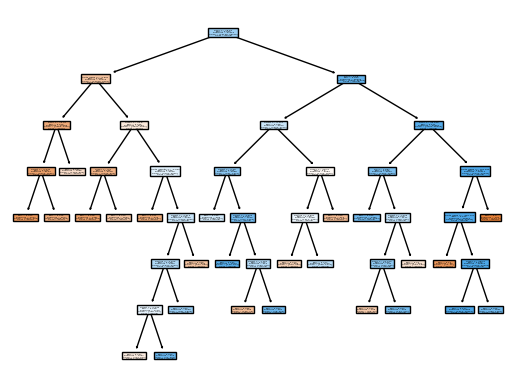

In [343]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train, sample_weight = weights)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Find the optimal alpha value
#optimal_alpha = ccp_alphas[np.argmax(impurities)]

# Prune the Decision Tree using the optimal alpha value
param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 200), #100, 200, 300, 400, 500], #np.arange(500, 200)
    'ccp_alpha': np.arange(0.0001, 0.013, 0.0005) }


# Create the Decision Tree classifier
#cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=20,random_state=1) ## 10-fold cross validations

#X_train, y_train = oversample.fit_resample(X_train, y_train)

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10) #, ccp_alpha=0.00385301)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'delta_cases', 'deaths', 'delta_death','admit', 'delta_admits','icu', 'delta_icu','beds', 'delta_beds'	], class_names=['above', 'below'], filled=True)




In [45]:
random_search.best_params_

{'min_samples_split': 40,
 'min_samples_leaf': 68,
 'max_depth': 7,
 'criterion': 'gini',
 'ccp_alpha': 0.0006000000000000001}

Accuracy: 0.9131165481122488
[[  310    90]
 [ 2133 23053]]


[Text(0.4296875, 0.9375, 'beds <= 15.88\ngini = 0.444\nsamples = 57412\nvalue = [19136, 38276]\nclass = below'),
 Text(0.171875, 0.8125, 'delta_beds <= -0.697\ngini = 0.448\nsamples = 19073\nvalue = [12606, 6467]\nclass = above'),
 Text(0.09375, 0.6875, 'beds <= 10.02\ngini = 0.366\nsamples = 10089\nvalue = [7659, 2430]\nclass = above'),
 Text(0.0625, 0.5625, 'admit <= 0.046\ngini = 0.316\nsamples = 8104\nvalue = [6509, 1595]\nclass = above'),
 Text(0.03125, 0.4375, 'gini = 0.252\nsamples = 4227\nvalue = [3601, 626]\nclass = above'),
 Text(0.09375, 0.4375, 'gini = 0.375\nsamples = 3877\nvalue = [2908, 969]\nclass = above'),
 Text(0.125, 0.5625, 'gini = 0.487\nsamples = 1985\nvalue = [1150, 835]\nclass = above'),
 Text(0.25, 0.6875, 'cases <= 21.5\ngini = 0.495\nsamples = 8984\nvalue = [4947, 4037]\nclass = above'),
 Text(0.1875, 0.5625, 'cases <= 9.5\ngini = 0.395\nsamples = 3078\nvalue = [2243, 835]\nclass = above'),
 Text(0.15625, 0.4375, 'gini = 0.308\nsamples = 1481\nvalue = [1199,

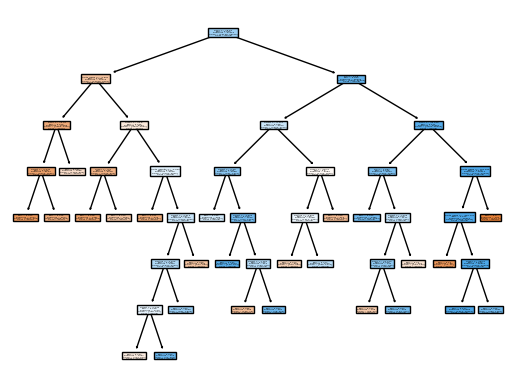

In [48]:
#best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10) #, ccp_alpha=0.00385301)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'delta_cases', 'deaths', 'delta_death','admit', 'delta_admits','icu', 'delta_icu','beds', 'delta_beds'	], class_names=['above', 'below'], filled=True)


In [49]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 49 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 8] <= 15.880155563354492 else to node 20.
	node=1 is a split node: go to node 2 if X[:, 9] <= -0.6966110467910767 else to node 7.
		node=2 is a split node: go to node 3 if X[:, 8] <= 10.02023983001709 else to node 6.
			node=3 is a split node: go to node 4 if X[:, 4] <= 0.04564567655324936 else to node 5.
				node=4 is a leaf node.
				node=5 is a leaf node.
			node=6 is a leaf node.
		node=7 is a split node: go to node 8 if X[:, 0] <= 21.5 else to node 11.
			node=8 is a split node: go to node 9 if X[:, 0] <= 9.5 else to node 10.
				node=9 is a leaf node.
				node=10 is a leaf node.
			node=11 is a split node: go to node 12 if X[:, 5] <= -0.9526207447052002 else to node 13.
				node=12 is a leaf node.
				node=13 is a split node: go to node 14 if X[:, 4] <= 2.9126687049865723 else to node 19.
					node=14 is a split node: go to node 15 if X[:, 2] <= 0.02908948250

# Use HSAs 

In [392]:
data_by_HSA[data_by_HSA['HSA_ID'] == '485Harrison']

,Unnamed: 0,date,health_service_area_number,health_service_area,health_service_area_population,cases_avg,deaths_avg,cases_avg_per_100k,deaths_avg_per_100k,POPESTIMATE2019,...,change_admits,change_perc,change_cases,zeke_time_3_14d,two_zeke_time_3_14d,state,weight,weight_alt,HSA_ID,beds_over_15_100k
6096,6097,2020-08-26,485,"Harrison (Marshall), TX - Cass, TX",106433,9.64,0.89,9.057341,0.836207,106433,...,0.0,0.0,-3.0,True,True,485,0.000321,0.001244,485Harrison,0


In [442]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3448/4285004469.py:1: DtypeWarning: Columns (50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data.csv')


In [443]:
data_by_HSA_cases = data_by_HSA[['HSA_ID', 'week', 'cases_weekly']]
data_by_HSA_cases = data_by_HSA_cases.pivot_table(index= 'week', columns='HSA_ID', values='cases_weekly')
data_by_HSA_deaths = data_by_HSA[['HSA_ID', 'week', 'deaths_weekly']]
data_by_HSA_deaths = data_by_HSA_deaths.pivot_table(index= 'week', columns='HSA_ID', values='deaths_weekly')
data_by_HSA_admissions = data_by_HSA[['HSA_ID', 'week', 'admits_weekly']]
data_by_HSA_admissions = data_by_HSA_admissions.pivot_table(index= 'week', columns='HSA_ID', values='admits_weekly')
data_by_HSA_icu = data_by_HSA[['HSA_ID', 'week', 'icu_weekly']]
data_by_HSA_icu = data_by_HSA_icu.pivot_table(index= 'week', columns='HSA_ID', values='icu_weekly')
data_by_HSA_beds = data_by_HSA[['HSA_ID', 'week', 'beds_weekly']]
data_by_HSA_beds = data_by_HSA_beds.pivot_table(index= 'week', columns='HSA_ID', values='beds_weekly')
data_by_HSA_over_15_100k = data_by_HSA[['HSA_ID', 'week', 'beds_over_15_100k']]
data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.pivot_table(index= 'week', columns='HSA_ID', values='beds_over_15_100k')
#data_by_HSA_over_15_100k = data_by_HSA_over_15_100k.add_suffix('_beds_over_15_100k')



data_data_cases_death_weekly = pd.merge(data_by_HSA_cases, data_by_HSA_deaths, on='week')
new_column_names = [col.replace('_x', '_cases') for col in data_data_cases_death_weekly.columns]
data_data_cases_death_weekly.rename(columns=dict(zip(data_data_cases_death_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_deaths') for col in data_data_cases_death_weekly.columns]
data_data_cases_death_weekly.rename(columns=dict(zip(data_data_cases_death_weekly.columns, new_column_names)), inplace=True)

data_data_admits_icu_weekly = pd.merge(data_by_HSA_admissions, data_by_HSA_icu, on='week')
new_column_names = [col.replace('_x', '_admit') for col in data_data_admits_icu_weekly.columns]
data_data_admits_icu_weekly.rename(columns=dict(zip(data_data_admits_icu_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_icu') for col in data_data_admits_icu_weekly.columns]
data_data_admits_icu_weekly.rename(columns=dict(zip(data_data_admits_icu_weekly.columns, new_column_names)), inplace=True)

data_data_beds_over_weekly = pd.merge(data_by_HSA_beds, data_by_HSA_over_15_100k, on='week')
new_column_names = [col.replace('_x', '_beds') for col in data_data_beds_over_weekly.columns]
data_data_beds_over_weekly.rename(columns=dict(zip(data_data_beds_over_weekly.columns, new_column_names)), inplace=True)

new_column_names = [col.replace('_y', '_beds_over_15_100k') for col in data_data_beds_over_weekly.columns]
data_data_beds_over_weekly.rename(columns=dict(zip(data_data_beds_over_weekly.columns, new_column_names)), inplace=True)



data_by_HSA_cases_deaths_admits_icu = pd.merge(data_data_cases_death_weekly, data_data_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_data_beds_over_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')


In [444]:
column_names = ['HSA_ID']
categories_for_subsetting = ['cases', 'deaths', 'admit', 'icu', 'beds', 'beds_over_15_100k']

for week in range(1, len(data_by_HSA_cases_deaths_admits_icu_beds) + 1):
    week = num2words(week)
    for category in categories_for_subsetting:
        column_name = f'week_{week}_{category}'
        column_names.append(column_name)

all_HSA_ID_weekly_data = pd.DataFrame(index=range(51), columns=column_names)

x = 0

categories_for_subsetting = ['cases', 'deaths', 'admit', 'icu', 'beds', 'beds_over_15_100k']
for HSA in data_by_HSA['HSA_ID'].unique():
    matching_indices = [i for i, HSA_col in enumerate(data_by_HSA_cases_deaths_admits_icu_beds) if HSA_col == HSA]
    all_HSA_ID_weekly_data.loc[x, 'HSA_ID'] = HSA
    columns_to_subset =  tuple([f'{HSA}_{category}' for category in categories_for_subsetting]) 
    columns_to_subset =  [f'{HSA}_{category}' for category in categories_for_subsetting]
 
    j = 1
    try:
        for row in range(len(data_by_HSA_cases_deaths_admits_icu_beds.loc[:, columns_to_subset])):
            all_HSA_ID_weekly_data.iloc[x, j:j + len(categories_for_subsetting)] = data_by_HSA_cases_deaths_admits_icu_beds.loc[row,columns_to_subset]
            j += 6
    except:
        pass
    x += 1

for column in all_HSA_ID_weekly_data.columns[1:]:
    # Calculate the difference between each row and the previous row
    if "over" not in column.lower():
        diff = all_HSA_ID_weekly_data[column].diff()
        
        # Create a new column with the original column name and "delta"
        new_column_name = column + "_delta"
        
        column_index = all_HSA_ID_weekly_data.columns.get_loc(column)
        
        # Insert the new column just after the original column
        all_HSA_ID_weekly_data.insert(column_index + 1, new_column_name, diff)
        all_HSA_ID_weekly_data[new_column_name] = diff



/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3448/1977984337.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_HSA_ID_weekly_data.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3448/1977984337.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_HSA_ID_weekly_data.insert(column_index + 1, new_column_name, diff)
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3448/1977984337.py:41: PerformanceWarning: DataFrame is highly fragmented.  T

In [ ]:
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

In [457]:

oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=10) #need for neural network and random forest


## Get actual test/train set 

X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data, [3,2], no_weeks = range(1, int(24*2/3) + 1), weeks_in_futre = 4, if_train = True, geography = 'HSA_ID', weight_col = 'weight')

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data, [3,2], no_weeks = range(int(24*2/3) + 1, 25), weeks_in_futre = 4, if_train = False, geography = 'HSA_ID',  weight_col = 'weight')
weights = weights[0].to_numpy()


[2.2388059701492535, 1.9900497512437811, 2.2388059701492535, 1.4925373134328357, 1.4925373134328357, 1.4925373134328357, 1.4925373134328357, 1.7412935323383085, 1.4925373134328357, 1.4925373134328357, 1.7412935323383085, 1.7412935323383085, 1.4925373134328357, 1.4925373134328357, 1.4925373134328357, 1.4925373134328357]
26.616915422885562
[0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906, 0.9950248756218906]
7.960199004975125


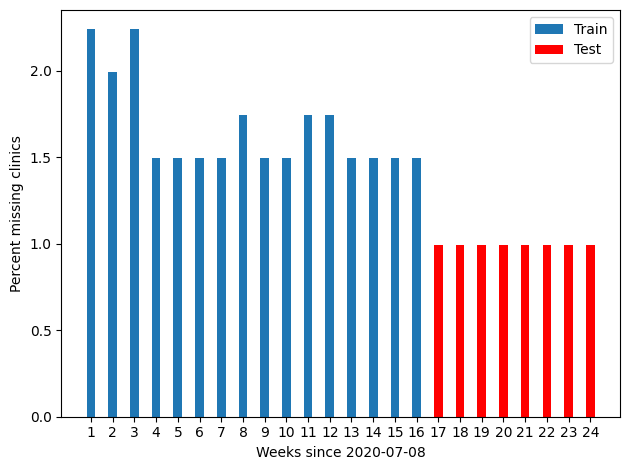

In [449]:
print(missing_data_train_HSA)
print(sum(missing_data_train_HSA))
print(missing_data_test_HSA)
print(sum(missing_data_test_HSA))

width = 0.4
x = np.arange(len(missing_data_train_HSA) + len(missing_data_test_HSA))
fig, ax = plt.subplots()
ax.bar(x[:len(missing_data_train_HSA)], missing_data_train_HSA, width, label='Train')
ax.bar(x[len(missing_data_train_HSA):], missing_data_test_HSA, width, label='Test', color='red')

# Labels and title
ax.set_xlabel('Weeks since 2020-07-08')
ax.set_ylabel('Percent missing clinics')
ax.set_xticks(x)
ax.set_xticklabels(labels = x+1, rotation=0, fontsize=10)

ax.legend()

plt.tight_layout()

plt.savefig('Graphs/Percent_missing_HSA.png', dpi = 300)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1358762779071876


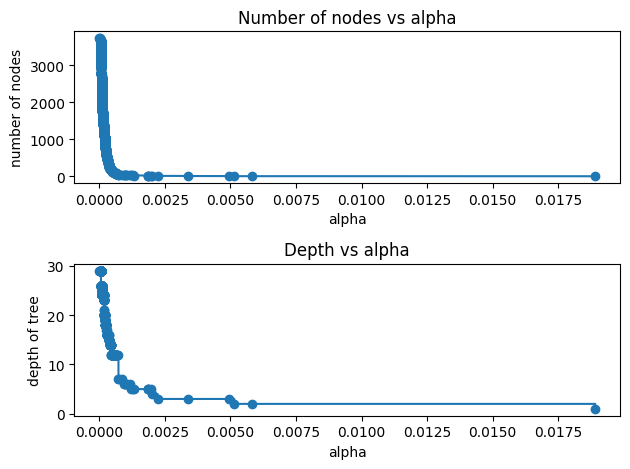

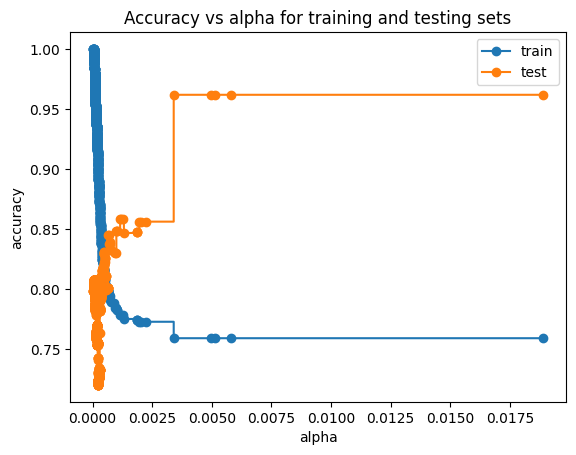

Best Hyperparameters:  {'min_samples_split': 40, 'min_samples_leaf': 68, 'max_depth': 7, 'criterion': 'gini', 'ccp_alpha': 0.0006000000000000001}
Best Score:  0.7818101945150421
Accuracy: 0.7947550251256281
[[ 171   45]
 [1262 4890]]


[Text(0.375, 0.9375, 'beds <= 15.88\ngini = 0.5\nsamples = 16812\nvalue = [8406, 8406]\nclass = above'),
 Text(0.1346153846153846, 0.8125, 'deaths <= 0.119\ngini = 0.334\nsamples = 7564\nvalue = [5962, 1602]\nclass = above'),
 Text(0.11538461538461539, 0.6875, 'gini = 0.126\nsamples = 1792\nvalue = [1671, 121]\nclass = above'),
 Text(0.15384615384615385, 0.6875, 'delta_beds <= -0.85\ngini = 0.381\nsamples = 5772\nvalue = [4291, 1481]\nclass = above'),
 Text(0.07692307692307693, 0.5625, 'beds <= 10.02\ngini = 0.301\nsamples = 3413\nvalue = [2783, 630]\nclass = above'),
 Text(0.038461538461538464, 0.4375, 'cases <= 24.5\ngini = 0.257\nsamples = 2746\nvalue = [2331, 415]\nclass = above'),
 Text(0.019230769230769232, 0.3125, 'gini = 0.1\nsamples = 682\nvalue = [646, 36]\nclass = above'),
 Text(0.057692307692307696, 0.3125, 'gini = 0.3\nsamples = 2064\nvalue = [1685, 379]\nclass = above'),
 Text(0.11538461538461539, 0.4375, 'deaths <= 1.954\ngini = 0.437\nsamples = 667\nvalue = [452, 215]\n

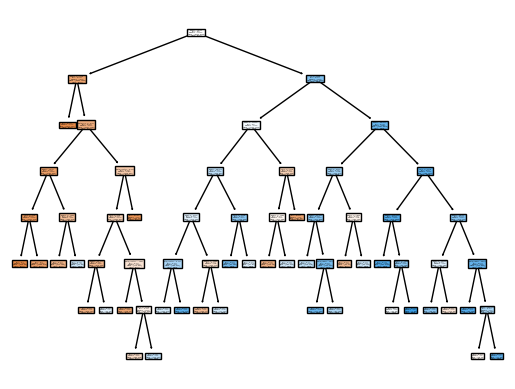

In [458]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Find the optimal alpha value
#optimal_alpha = ccp_alphas[np.argmax(impurities)]

# Prune the Decision Tree using the optimal alpha value
param_grid = {
    'criterion': ['gini'],#, 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split':  np.arange(2, 100), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 200), #100, 200, 300, 400, 500], #np.arange(500, 200)
    'ccp_alpha': np.arange(0.0001, 0.013, 0.0005) }


# Create the Decision Tree classifier
#cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=20,random_state=1) ## 10-fold cross validations

#X_train, y_train = oversample.fit_resample(X_train, y_train)

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight=weights)
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10) #, ccp_alpha=0.00385301)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases', 'delta_cases', 'deaths', 'delta_death','admit', 'delta_admits','icu', 'delta_icu','beds', 'delta_beds'	], class_names=['above', 'below'], filled=True)

